In [19]:

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# ЗАГРУЗКА ДАННЫХ


In [20]:
class DataLoader:
    @staticmethod
    def load_data():
        X_train_cnn = np.load('cnn_data_MULTICLASS/X_train_cnn.npy')
        X_val_cnn = np.load('cnn_data_MULTICLASS/X_val_cnn.npy')
        X_test_cnn = np.load('cnn_data_MULTICLASS/X_test_cnn.npy')
        
        y_train = np.load('cnn_data_MULTICLASS/y_train.npy')
        y_val = np.load('cnn_data_MULTICLASS/y_val.npy')
        y_test = np.load('cnn_data_MULTICLASS/y_test.npy')
        
        return X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test

# ПОДГОТОВКА ДАННЫХ

In [21]:
class DataPreprocessor:
    @staticmethod
    def prepare_for_1d_cnn(X_data):
        if len(X_data.shape) == 4 and X_data.shape[3] == 1:
            return X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2])
        elif len(X_data.shape) == 3:
            return X_data
        else:
            raise ValueError(f"Unexpected input shape: {X_data.shape}")

# МЕТРИКИ

In [22]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        self.threshold = threshold
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        denominator = precision + recall + tf.keras.backend.epsilon()
        return 2 * ((precision * recall) / denominator)
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

class MacroF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.f1_scores = [F1Score(threshold=threshold, name=f'f1_class_{i}') 
                         for i in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.f1_scores[i].update_state(y_true[:, i:i+1], y_pred[:, i:i+1], sample_weight)
        
    def result(self):
        f1_values = [f1_score.result() for f1_score in self.f1_scores]
        return tf.reduce_mean(f1_values)
    
    def reset_state(self):
        for f1_score in self.f1_scores:
            f1_score.reset_state()

# ФУНКЦИИ ПОТЕРЬ

In [23]:
class LossFactory:
    @staticmethod
    def create_weighted_loss(y_train, class_names):
        class_weights_info = []
        
        for i in range(len(class_names)):
            pos_samples = y_train[:, i].sum()
            neg_samples = len(y_train) - pos_samples
            
            weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
            weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
            
            total = weight_for_class_0 + weight_for_class_1
            weight_for_class_0 /= total
            weight_for_class_1 /= total
            
            class_weights_info.append({
                'name': class_names[i],
                'weight_0': float(weight_for_class_0),
                'weight_1': float(weight_for_class_1),
                'pos_samples': int(pos_samples),
                'neg_samples': int(neg_samples)
            })
            
            print(f"{class_names[i]}: вес класса 0={weight_for_class_0:.2f}, "
                  f"вес класса 1={weight_for_class_1:.2f}, "
                  f"положительных={pos_samples}")
        
        def weighted_binary_crossentropy(y_true, y_pred):
            # Создаем тензор весов той же формы, что и y_true
            batch_size = tf.shape(y_true)[0]
            num_classes = tf.shape(y_true)[1]
            
            weights = tf.zeros_like(y_true, dtype=tf.float32)
            
            for i, weights_dict in enumerate(class_weights_info):
                # Получаем метки для текущего класса
                class_mask = y_true[:, i]
                
                # Создаем веса для текущего класса
                class_weights = tf.where(
                    class_mask > 0.5,
                    weights_dict['weight_1'],
                    weights_dict['weight_0']
                )
                
                # Расширяем до формы [batch_size, 1]
                class_weights = tf.expand_dims(class_weights, axis=-1)
                
                # Создаем маску для обновления только текущего класса
                indices_i = tf.ones((batch_size, 1), dtype=tf.int32) * i
                indices_batch = tf.reshape(tf.range(batch_size), (-1, 1))
                indices = tf.concat([indices_batch, indices_i], axis=1)
                
                # Обновляем веса
                weights = tf.tensor_scatter_nd_update(
                    weights,
                    indices,
                    tf.squeeze(class_weights, axis=-1)
                )
            
            # Вычисляем бинарную кросс-энтропию
            bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
            
            # Среднее по всем классам и примерам
            weighted_loss = tf.reduce_mean(bce * weights)
            return weighted_loss
        
        # Альтернативная, более простая реализация
        def weighted_binary_crossentropy_v2(y_true, y_pred):
            loss = 0
            for i, weights_dict in enumerate(class_weights_info):
                # Для каждого класса отдельно
                y_true_i = y_true[:, i]
                y_pred_i = y_pred[:, i]
                
                # Веса для текущего класса
                weights_i = tf.where(
                    y_true_i > 0.5,
                    weights_dict['weight_1'],
                    weights_dict['weight_0']
                )
                
                # Кросс-энтропия для текущего класса
                bce_i = tf.keras.losses.binary_crossentropy(
                    tf.expand_dims(y_true_i, axis=-1),
                    tf.expand_dims(y_pred_i, axis=-1)
                )
                
                # Взвешенная потеря
                loss += tf.reduce_mean(bce_i * weights_i)
            
            return loss / len(class_weights_info)
        
        return weighted_binary_crossentropy_v2, class_weights_info


# АРХИТЕКТУРЫ МОДЕЛЕЙ

In [24]:
class FeatureExtractorFactory:
    @staticmethod
    def create_standard(input_shape, num_features=32):
        model = models.Sequential(name="1D_CNN_Feature_Extractor")
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', 
                               input_shape=input_shape, name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_by_features(input_shape, num_features=32):
        model = models.Sequential(name="1D_CNN_By_Features_Extractor")
        model.add(layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1]), 
                               input_shape=input_shape, 
                               name='transpose'))
        model.add(layers.Conv1D(32, 3, padding='same', activation='relu', name='conv1d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling1D(2, name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        model.add(layers.Conv1D(64, 3, padding='same', activation='relu', name='conv1d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling1D(2, name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        model.add(layers.Conv1D(128, 3, padding='same', activation='relu', name='conv1d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.GlobalAveragePooling1D(name='global_avg_pool'))
        
        model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_bidirectional(input_shape, num_features=32):
        inputs = layers.Input(shape=input_shape, name='input')
        
        x = layers.Bidirectional(
            layers.Conv1D(32, 3, padding='same', activation='relu'), 
            name='bidirectional_conv1'
        )(inputs)
        x = layers.BatchNormalization(name='bn1')(x)
        x = layers.MaxPooling1D(2, name='pool1')(x)
        x = layers.Dropout(0.2, name='dropout1')(x)
        
        x = layers.Bidirectional(
            layers.Conv1D(64, 3, padding='same', activation='relu'), 
            name='bidirectional_conv2'
        )(x)
        x = layers.BatchNormalization(name='bn2')(x)
        x = layers.MaxPooling1D(2, name='pool2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        
        x = layers.Bidirectional(
            layers.Conv1D(128, 3, padding='same', activation='relu'), 
            name='bidirectional_conv3'
        )(x)
        x = layers.BatchNormalization(name='bn3')(x)
        x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
        
        x = layers.Dense(32, activation='relu', name='feature_dense1')(x)
        x = layers.Dropout(0.4, name='dropout3')(x)
        features = layers.Dense(num_features, activation=None, name='features')(x)
        
        return Model(inputs=inputs, outputs=features, name="Bidirectional_1D_CNN_Extractor")

# ПОЛНАЯ МОДЕЛЬ

In [25]:
class ModelFactory:
    @staticmethod
    def create_full_model(input_shape, num_classes, extractor_type='standard', 
                         num_features=32, use_class_weights=True, y_train=None):
        extractor_factory = FeatureExtractorFactory()
        
        if extractor_type == 'standard':
            feature_extractor = extractor_factory.create_standard(input_shape, num_features)
        elif extractor_type == 'by_features':
            feature_extractor = extractor_factory.create_by_features(input_shape, num_features)
        elif extractor_type == 'bidirectional':
            feature_extractor = extractor_factory.create_bidirectional(input_shape, num_features)
        else:
            raise ValueError(f"Unknown extractor_type: {extractor_type}")
        
        inputs = layers.Input(shape=input_shape)
        features = feature_extractor(inputs)
        
        # Классификационная головка
        if use_class_weights and y_train is not None:
            initial_biases = []
            for i in range(num_classes):
                pos_ratio = y_train[:, i].sum() / len(y_train)
                if pos_ratio > 0 and pos_ratio < 1:
                    initial_bias = np.log(pos_ratio / (1 - pos_ratio))
                else:
                    initial_bias = 0.0
                initial_biases.append(initial_bias)
            
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            
            output = layers.Dense(
                num_classes, 
                activation='sigmoid',
                name='output',
                kernel_initializer='glorot_normal',
                bias_initializer=tf.keras.initializers.Constant(initial_biases)
            )(x)
        else:
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            output = layers.Dense(num_classes, activation='sigmoid', name='output')(x)
        
        full_model = Model(inputs=inputs, outputs=output, 
                          name=f"1D_CNN_{extractor_type.capitalize()}")
        
        return full_model, feature_extractor

# ОПТИМИЗАЦИЯ ПОРОГОВ

In [26]:
class ThresholdOptimizer:
    @staticmethod
    def find_optimal_thresholds(model, X_val, y_val, class_names):
        y_pred_proba = model.predict(X_val, verbose=0)
        optimal_thresholds = []
        
        print("\n" + "="*50)
        print("ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ")
        print("="*50)
        
        for i, name in enumerate(class_names):
            y_true = y_val[:, i]
            y_prob = y_pred_proba[:, i]
            
            best_threshold = 0.5
            best_f1 = 0
            
            for threshold in np.arange(0.05, 0.95, 0.01):
                y_pred = (y_prob > threshold).astype(int)
                
                tp = np.sum((y_true == 1) & (y_pred == 1))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                
                if tp + fp > 0 and tp + fn > 0:
                    precision = tp / (tp + fp)
                    recall = tp / (tp + fn)
                    f1 = 2 * precision * recall / (precision + recall)
                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
            
            optimal_thresholds.append(best_threshold)
            print(f"{name}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
        
        return optimal_thresholds
    
    @staticmethod
    def evaluate_with_thresholds(model, X_test, y_test, class_names, optimal_thresholds):
        y_pred_proba_test = model.predict(X_test, verbose=0)
        results_summary = []
        
        for i, (name, threshold) in enumerate(zip(class_names, optimal_thresholds)):
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > threshold).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            accuracy = (tp + tn) / len(y_true)
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            
            results_summary.append({
                'name': name,
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                'pos_count': y_true.sum(),
                'neg_count': len(y_true) - y_true.sum()
            })
            
            print(f"\n{name} (порог={threshold:.2f}):")
            print(f"  F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  TP/FP/FN/TN: {tp}/{fp}/{fn}/{tn}")
            print(f"  Положительных: {y_true.sum()}/{len(y_true)} ({y_true.sum()/len(y_true)*100:.1f}%)")
        
        return results_summary, y_pred_proba_test


# ВИЗУАЛИЗАЦИЯ

In [27]:
class Visualizer:
    @staticmethod
    def visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                         class_names, optimal_thresholds, extractor_type):
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Графики обучения
        ax1 = plt.subplot(3, 4, 1)
        ax1.plot(history.history['loss'], label='Train')
        ax1.plot(history.history['val_loss'], label='Validation')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 4, 2)
        ax2.plot(history.history['macro_f1'], label='Train')
        ax2.plot(history.history['val_macro_f1'], label='Validation')
        ax2.set_title('Macro F1-score')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3 = plt.subplot(3, 4, 3)
        if 'auc' in history.history:
            ax3.plot(history.history['auc'], label='Train')
            ax3.plot(history.history['val_auc'], label='Validation')
            ax3.set_title('AUC')
            ax3.set_xlabel('Epoch')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 2. F1-score по классам
        ax4 = plt.subplot(3, 4, 4)
        f1_scores = [r['f1'] for r in results_summary]
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        bars = ax4.bar(class_names, f1_scores, color=colors)
        ax4.set_title('F1-score по классам')
        ax4.set_ylabel('F1-score')
        ax4.set_ylim(0, 1)
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Precision vs Recall
        ax5 = plt.subplot(3, 4, 5)
        precision_scores = [r['precision'] for r in results_summary]
        recall_scores = [r['recall'] for r in results_summary]
        
        x = np.arange(len(class_names))
        width = 0.35
        ax5.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue', alpha=0.8)
        ax5.bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8)
        ax5.set_title('Precision vs Recall по классам')
        ax5.set_xlabel('Класс')
        ax5.set_ylabel('Score')
        ax5.set_xticks(x)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.legend()
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 4. Оптимальные пороги
        ax6 = plt.subplot(3, 4, 6)
        thresholds = [r['threshold'] for r in results_summary]
        bars = ax6.bar(class_names, thresholds, color='lightgreen', alpha=0.7)
        ax6.set_title('Оптимальные пороги по классам')
        ax6.set_ylabel('Порог')
        ax6.set_ylim(0, 1)
        for bar, threshold in zip(bars, thresholds):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{threshold:.2f}', ha='center', va='bottom', fontsize=9)
        ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Стандартный порог (0.5)')
        ax6.legend()
        
        # 5. Распределение классов
        ax7 = plt.subplot(3, 4, 7)
        pos_counts = [r['pos_count'] for r in results_summary]
        neg_counts = [r['neg_count'] for r in results_summary]
        
        ax7.bar(class_names, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
        ax7.bar(class_names, pos_counts, bottom=neg_counts, label='Положительные (1)', 
               color='darkred', alpha=0.7)
        ax7.set_title('Распределение классов в тестовой выборке')
        ax7.set_xlabel('Класс')
        ax7.set_ylabel('Количество образцов')
        ax7.legend()
        ax7.tick_params(axis='x', rotation=45)
        
        # 6. ROC-кривые
        ax8 = plt.subplot(3, 4, 8)
        ax8.set_title('ROC-кривые по классам')
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
        for i, (name, color) in enumerate(zip(class_names, colors)):
            y_true = y_test[:, i]
            y_prob = y_pred_proba_test[:, i]
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax8.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC={roc_auc:.3f})')
        
        ax8.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        ax8.set_xlabel('False Positive Rate')
        ax8.set_ylabel('True Positive Rate')
        ax8.legend(loc='lower right', fontsize=8)
        ax8.grid(True, alpha=0.3)
        
        # 7. Confusion Matrices
        num_matrices = min(4, len(class_names))
        for i, name in enumerate(class_names[:num_matrices]):
            ax = plt.subplot(3, 4, 9 + i)
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > optimal_thresholds[i]).astype(int)
            
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['True 0', 'True 1'],
                       ax=ax, cbar=False)
            ax.set_title(f'Confusion Matrix: {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        # 8. Общая статистика
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        avg_precision = np.mean([r['precision'] for r in results_summary])
        avg_recall = np.mean([r['recall'] for r in results_summary])
        macro_f1 = history.history['val_macro_f1'][-1] if 'val_macro_f1' in history.history else avg_f1
        
        stats_text = [
            f'ОБЩАЯ СТАТИСТИКА:',
            f'',
            f'Средний F1-score: {avg_f1:.4f}',
            f'Macro F1-score: {macro_f1:.4f}',
            f'Средний Precision: {avg_precision:.4f}',
            f'Средний Recall: {avg_recall:.4f}',
            f'',
            f'Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]}',
            f'Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]}',
            f'',
            f'Эпох обучения: {len(history.history["loss"])}'
        ]
        
        ax12.text(0.1, 0.9, '\n'.join(stats_text), 
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Результаты модели 1D CNN ({extractor_type})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Корреляционные матрицы
        if len(class_names) > 1:
            fig2, ax = plt.subplots(1, 2, figsize=(15, 6))
            
            y_pred_all = np.zeros_like(y_pred_proba_test)
            for i, threshold in enumerate(optimal_thresholds):
                y_pred_all[:, i] = (y_pred_proba_test[:, i] > threshold).astype(int)
            
            pred_corr = np.corrcoef(y_pred_all.T)
            im1 = ax[0].imshow(pred_corr, cmap='coolwarm', vmin=-1, vmax=1)
            ax[0].set_title('Корреляция между предсказаниями классов')
            ax[0].set_xticks(range(len(class_names)))
            ax[0].set_yticks(range(len(class_names)))
            ax[0].set_xticklabels(class_names, rotation=45)
            ax[0].set_yticklabels(class_names)
            plt.colorbar(im1, ax=ax[0])
            
            for i in range(len(class_names)):
                for j in range(len(class_names)):
                    ax[0].text(j, i, f'{pred_corr[i, j]:.2f}', 
                              ha='center', va='center', color='white', fontsize=8)
            
            true_corr = np.corrcoef(y_test.T)
            im2 = ax[1].imshow(true_corr, cmap='coolwarm', vmin=-1, vmax=1)
            ax[1].set_title('Корреляция между истинными метками классов')
            ax[1].set_xticks(range(len(class_names)))
            ax[1].set_yticks(range(len(class_names)))
            ax[1].set_xticklabels(class_names, rotation=45)
            ax[1].set_yticklabels(class_names)
            plt.colorbar(im2, ax=ax[1])
            
            for i in range(len(class_names)):
                for j in range(len(class_names)):
                    ax[1].text(j, i, f'{true_corr[i, j]:.2f}', 
                              ha='center', va='center', color='white', fontsize=8)
            
            plt.tight_layout()
            plt.show()

# ОСНОВНОЙ ПРОЦЕСС

## Standart

ЗАГРУЗКА ДАННЫХ
ПОДГОТОВКА ДАННЫХ
X_train_1d shape: (999, 25, 16)
X_val_1d shape: (429, 25, 16)
X_test_1d shape: (612, 25, 16)
СОЗДАНИЕ ВЗВЕШЕННОЙ ФУНКЦИИ ПОТЕРЬ
hu: вес класса 0=0.02, вес класса 1=0.98, положительных=22.0
hg: вес класса 0=0.01, вес класса 1=0.99, положительных=8.0
hs: вес класса 0=0.04, вес класса 1=0.96, положительных=44.0
hm: вес класса 0=0.03, вес класса 1=0.97, положительных=29.0
hi: вес класса 0=0.17, вес класса 1=0.83, положительных=169.0
СОЗДАНИЕ МОДЕЛИ


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "1D_CNN_Standard"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1D_CNN_Feature_Extractor        │ (None, 20)             │        38,164 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,681 (151.10 KB)

 Trainable params: 38,233 (149.35 KB)

 Non-trainable params: 448 (1.75 KB)

НАЧАЛО ОБУЧЕНИЯ

Epoch 1: val_macro_f1 improved from None to 0.00000, saving model to best_1d_cnn_standard_model.h5



Epoch 2: val_macro_f1 did not improve from 0.00000

Epoch 3: val_macro_f1 improved from 0.00000 to 0.05843, saving model to best_1d_cnn_standard_model.h5



Epoch 4: val_macro_f1 improved from 0.05843 to 0.12000, saving model to best_1d_cnn_standard_model.h5



Epoch 5: val_macro_f1 improved from 0.12000 to 0.32156, saving model to best_1d_cnn_standard_model.h5



Epoch 6: val_macro_f1 improved from 0.32156 to 0.34018, saving model to best_1d_cnn_standard_model.h5



Epoch 7: val_macro_f1 did not improve from 0.34018

Epoch 8: val_macro_f1 did not improve from 0.34018

Epoch 9: val_macro_f1 did not improve from 0.34018

Epoch 10: val_macro_f1 improved from 0.34018 to 0.34304, saving model to best_1d_cnn_standard_model.h5



Epoch 11: val_macro_f1 did not improve from 0.34304

Epoch 12: val_macro_f1 did not improve from 0.34304

Epoch 13: val_macro_f1 improved from 0.34304 to 0.36016, saving model to best_1d_cnn_standard_model.h5



Epoch 14: val_macro_f1 did not improve from 0.36016

Epoch 15: val_macro_f1 did not improve from 0.36016

Epoch 16: val_macro_f1 improved from 0.36016 to 0.38340, saving model to best_1d_cnn_standard_model.h5



Epoch 17: val_macro_f1 did not improve from 0.38340

Epoch 18: val_macro_f1 did not improve from 0.38340

Epoch 19: val_macro_f1 did not improve from 0.38340

Epoch 20: val_macro_f1 did not improve from 0.38340

Epoch 21: val_macro_f1 did not improve from 0.38340

Epoch 22: val_macro_f1 did not improve from 0.38340

Epoch 23: val_macro_f1 did not improve from 0.38340

Epoch 24: val_macro_f1 did not improve from 0.38340

Epoch 25: val_macro_f1 improved from 0.38340 to 0.39949, saving model to best_1d_cnn_standard_model.h5



Epoch 26: val_macro_f1 did not improve from 0.39949

Epoch 27: val_macro_f1 did not improve from 0.39949

Epoch 28: val_macro_f1 did not improve from 0.39949

Epoch 29: val_macro_f1 improved from 0.39949 to 0.40288, saving model to best_1d_cnn_standard_model.h5



Epoch 30: val_macro_f1 did not improve from 0.40288

Epoch 31: val_macro_f1 did not improve from 0.40288

Epoch 32: val_macro_f1 did not improve from 0.40288

Epoch 33: val_macro_f1 did not improve from 0.40288

Epoch 34: val_macro_f1 improved from 0.40288 to 0.41186, saving model to best_1d_cnn_standard_model.h5



Epoch 35: val_macro_f1 did not improve from 0.41186

Epoch 36: val_macro_f1 did not improve from 0.41186

Epoch 37: val_macro_f1 improved from 0.41186 to 0.41846, saving model to best_1d_cnn_standard_model.h5



Epoch 38: val_macro_f1 improved from 0.41846 to 0.43072, saving model to best_1d_cnn_standard_model.h5



Epoch 39: val_macro_f1 did not improve from 0.43072

Epoch 40: val_macro_f1 did not improve from 0.43072

Epoch 41: val_macro_f1 improved from 0.43072 to 0.43119, saving model to best_1d_cnn_standard_model.h5



Epoch 42: val_macro_f1 improved from 0.43119 to 0.43461, saving model to best_1d_cnn_standard_model.h5



Epoch 43: val_macro_f1 did not improve from 0.43461

Epoch 44: val_macro_f1 did not improve from 0.43461

Epoch 45: val_macro_f1 did not improve from 0.43461

Epoch 46: val_macro_f1 did not improve from 0.43461

Epoch 47: val_macro_f1 improved from 0.43461 to 0.45817, saving model to best_1d_cnn_standard_model.h5



Epoch 48: val_macro_f1 did not improve from 0.45817

Epoch 49: val_macro_f1 did not improve from 0.45817

Epoch 50: val_macro_f1 did not improve from 0.45817

Epoch 51: val_macro_f1 did not improve from 0.45817

Epoch 52: val_macro_f1 did not improve from 0.45817

Epoch 53: val_macro_f1 did not improve from 0.45817

Epoch 54: val_macro_f1 did not improve from 0.45817

Epoch 55: val_macro_f1 did not improve from 0.45817

Epoch 56: val_macro_f1 did not improve from 0.45817

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: val_macro_f1 did not improve from 0.45817

Epoch 58: val_macro_f1 did not improve from 0.45817

Epoch 59: val_macro_f1 did not improve from 0.45817

Epoch 60: val_macro_f1 did not improve from 0.45817

Epoch 61: val_macro_f1 improved from 0.45817 to 0.47571, saving model to best_1d_cnn_standard_model.h5



Epoch 62: val_macro_f1 did not improve from 0.47571

Epoch 63: val_macro_f1 did not improve from 0.47571

Epoch 64: val_macro_f1 did not improve from 0.47571

Epoch 65: val_macro_f1 did not improve from 0.47571

Epoch 66: val_macro_f1 did not improve from 0.47571

Epoch 67: val_macro_f1 did not improve from 0.47571

Epoch 68: val_macro_f1 did not improve from 0.47571

Epoch 69: val_macro_f1 improved from 0.47571 to 0.47766, saving model to best_1d_cnn_standard_model.h5



Epoch 70: val_macro_f1 improved from 0.47766 to 0.49376, saving model to best_1d_cnn_standard_model.h5



Epoch 71: val_macro_f1 improved from 0.49376 to 0.50424, saving model to best_1d_cnn_standard_model.h5



Epoch 72: val_macro_f1 did not improve from 0.50424

Epoch 73: val_macro_f1 did not improve from 0.50424

Epoch 74: val_macro_f1 did not improve from 0.50424

Epoch 75: val_macro_f1 did not improve from 0.50424

Epoch 76: val_macro_f1 did not improve from 0.50424

Epoch 77: val_macro_f1 did not improve from 0.50424

Epoch 78: val_macro_f1 did not improve from 0.50424

Epoch 79: val_macro_f1 did not improve from 0.50424

Epoch 80: val_macro_f1 did not improve from 0.50424

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 81: val_macro_f1 did not improve from 0.50424

Epoch 82: val_macro_f1 did not improve from 0.50424

Epoch 83: val_macro_f1 did not improve from 0.50424

Epoch 84: val_macro_f1 improved from 0.50424 to 0.51483, saving model to best_1d_cnn_standard_model.h5



Epoch 85: val_macro_f1 did not improve from 0.51483

Epoch 86: val_macro_f1 did not improve from 0.51483

Epoch 87: val_macro_f1 did not improve from 0.51483

Epoch 88: val_macro_f1 did not improve from 0.51483

Epoch 89: val_macro_f1 did not improve from 0.51483

Epoch 90: val_macro_f1 did not improve from 0.51483

Epoch 91: val_macro_f1 did not improve from 0.51483

Epoch 92: val_macro_f1 did not improve from 0.51483

Epoch 93: val_macro_f1 did not improve from 0.51483

Epoch 94: val_macro_f1 improved from 0.51483 to 0.53447, saving model to best_1d_cnn_standard_model.h5



Epoch 95: val_macro_f1 did not improve from 0.53447

Epoch 96: val_macro_f1 did not improve from 0.53447

Epoch 97: val_macro_f1 did not improve from 0.53447

Epoch 98: val_macro_f1 did not improve from 0.53447

Epoch 99: val_macro_f1 did not improve from 0.53447

Epoch 100: val_macro_f1 did not improve from 0.53447

Epoch 101: val_macro_f1 did not improve from 0.53447

Epoch 102: val_macro_f1 did not improve from 0.53447

Epoch 103: val_macro_f1 did not improve from 0.53447

Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 104: val_macro_f1 did not improve from 0.53447

Epoch 105: val_macro_f1 did not improve from 0.53447

Epoch 106: val_macro_f1 did not improve from 0.53447

Epoch 107: val_macro_f1 did not improve from 0.53447

Epoch 108: val_macro_f1 did not improve from 0.53447

Epoch 109: val_macro_f1 did not improve from 0.53447

Epoch 110: val_macro_f1 did not improve from 0.53447

Epoch 111: val_macro_f1 did not improve from 0.53447

Epoch 1

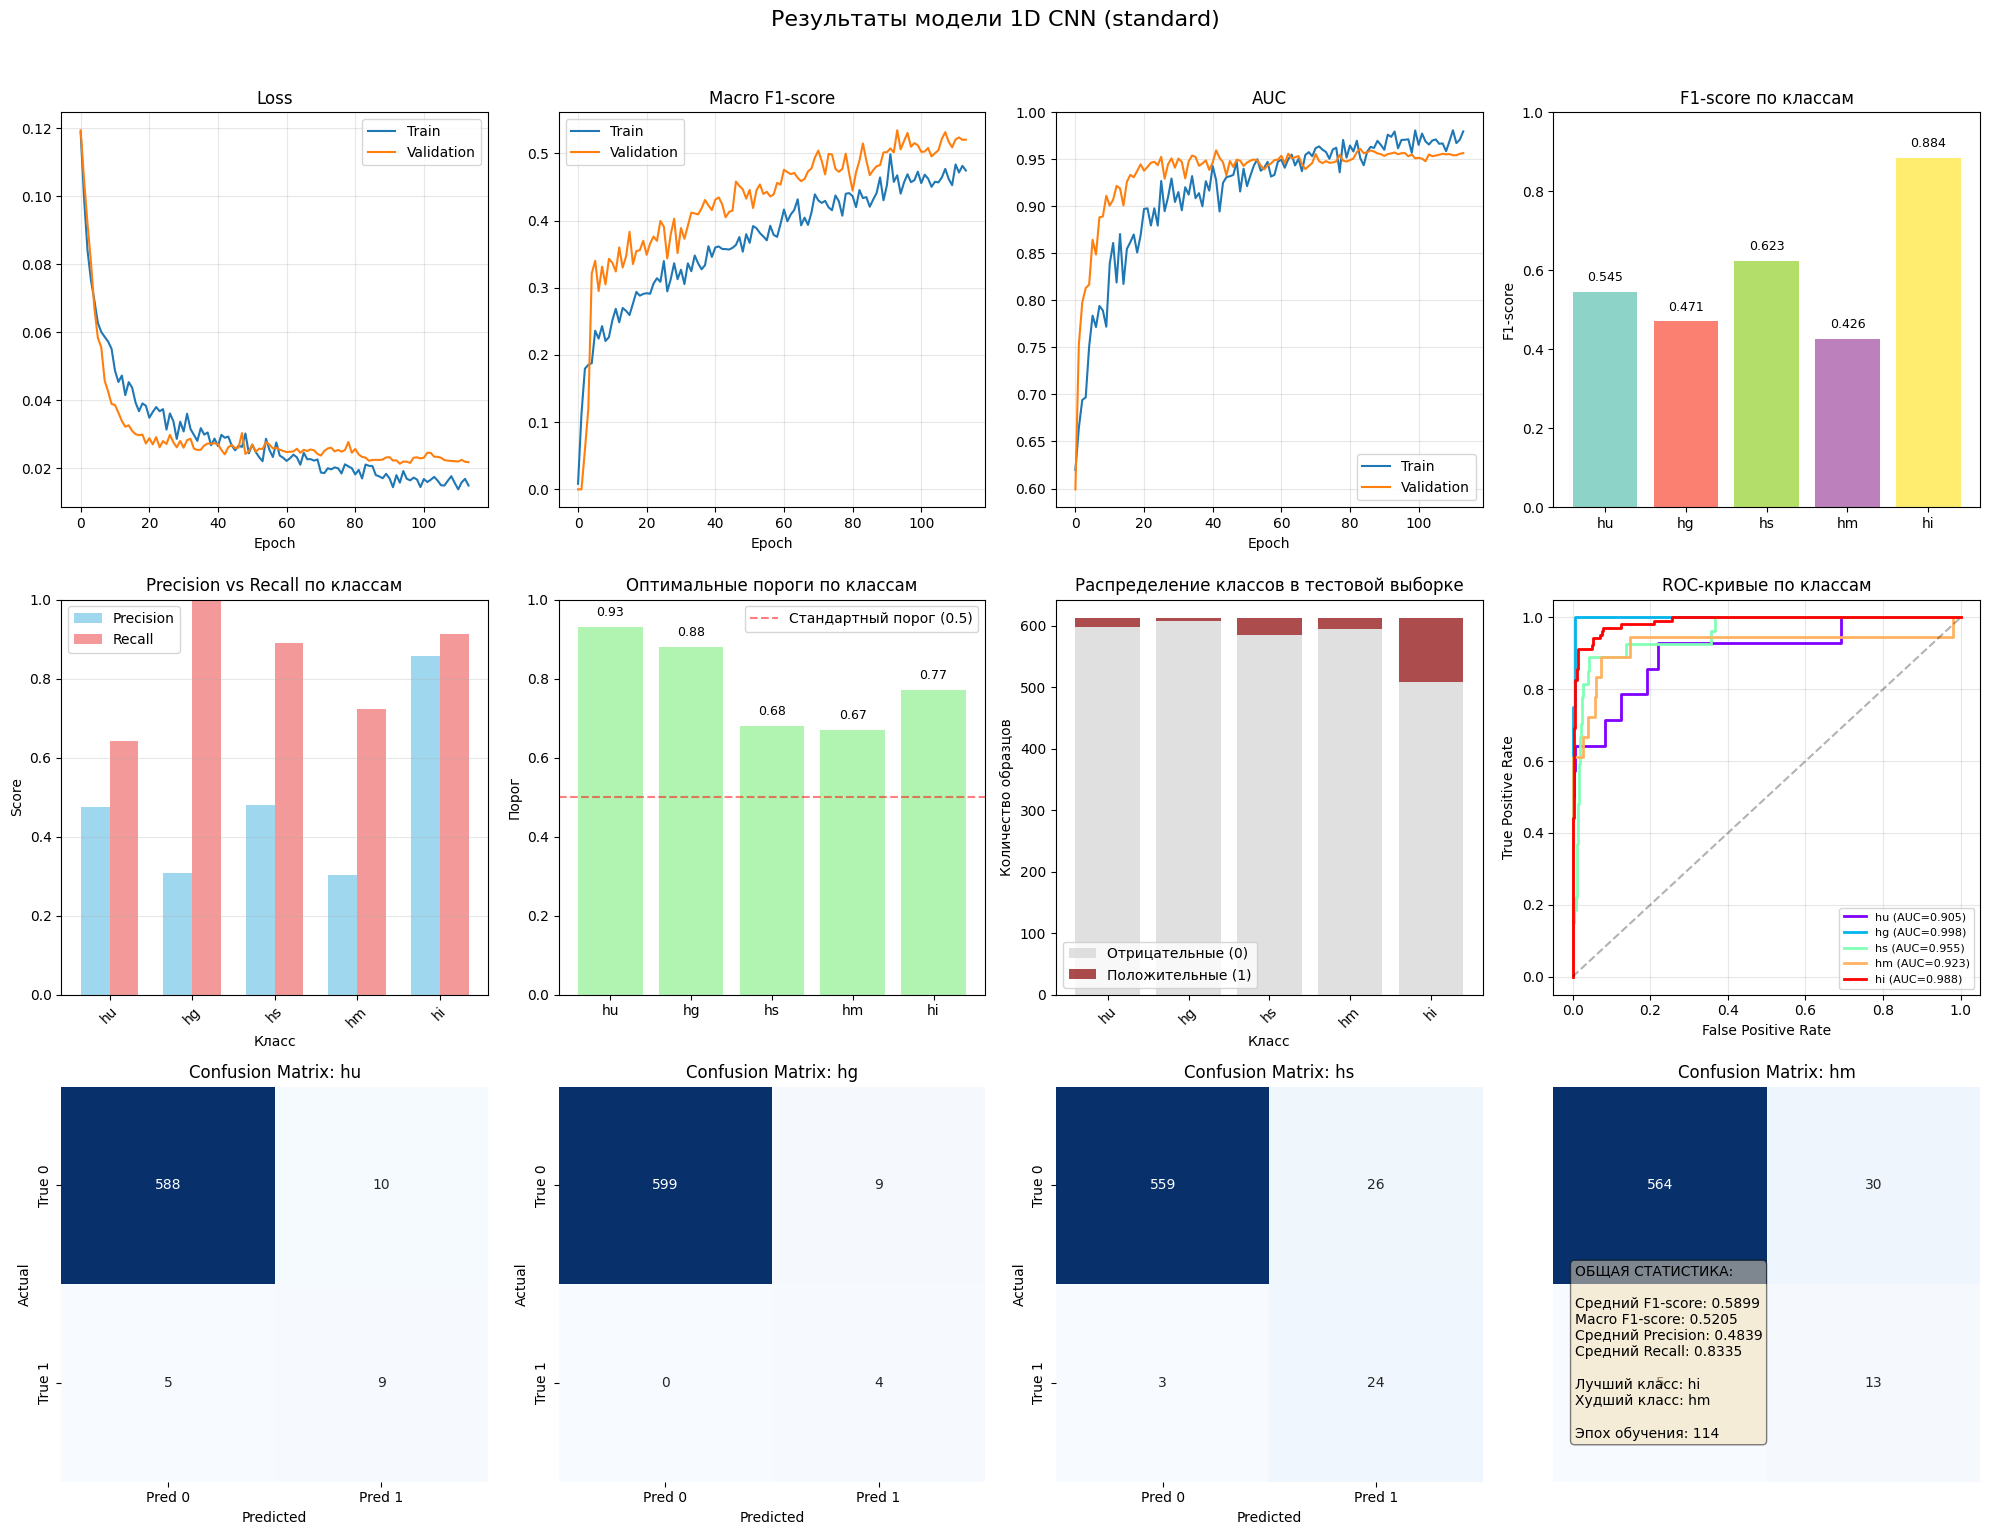

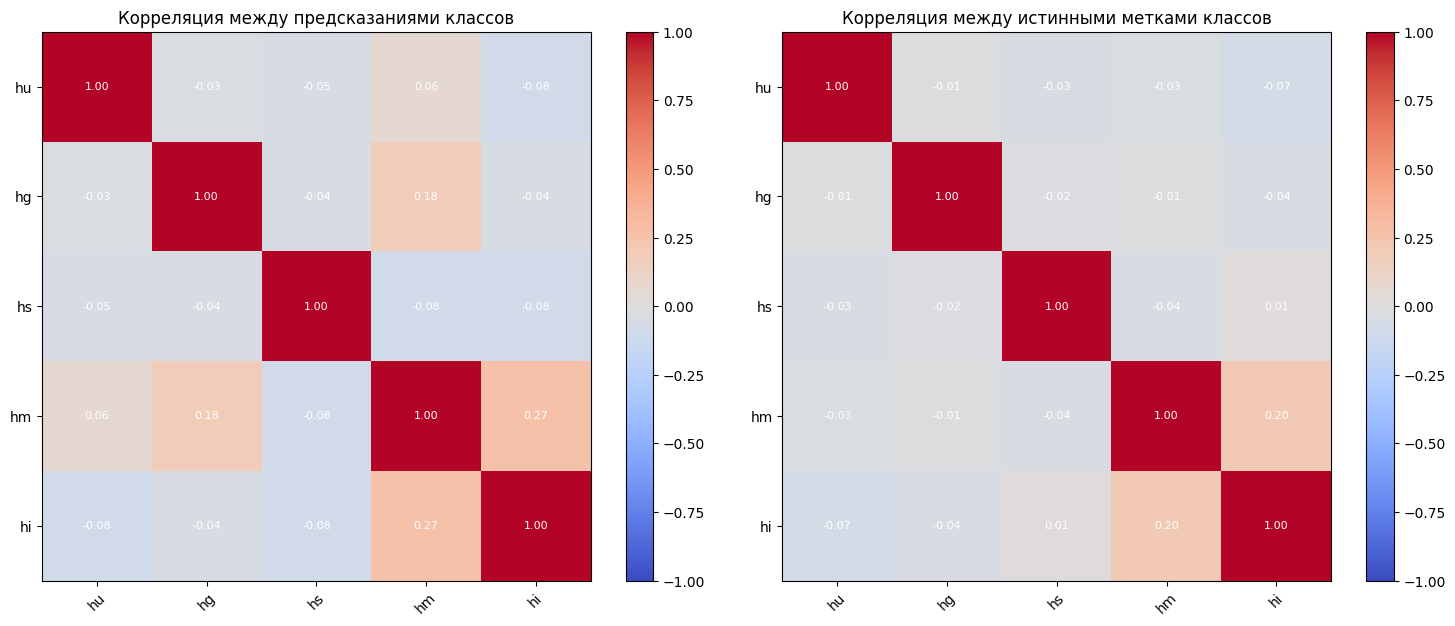

ФИНАЛЬНЫЕ ВЫВОДЫ

 Модель успешно обучена!
  Лучший валидационный Macro F1-score: 0.5345
  Средний тестовый F1-score: 0.5899
  Лучшая эпоха: 94
  Использованные пороги: ['0.93', '0.88', '0.68', '0.67', '0.77']
  Архитектура: 1D CNN (standard)


In [42]:

# Конфигурация
INPUT_SHAPE = (25, 16)
NUM_CLASSES = 5
CLASS_NAMES = ['hu', 'hg', 'hs', 'hm', 'hi']
EXTRACTOR_TYPE = 'standard'

# 1. Загрузка данных
print("ЗАГРУЗКА ДАННЫХ")

data_loader = DataLoader()
X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()

# 2. Подготовка данных
print("ПОДГОТОВКА ДАННЫХ")

preprocessor = DataPreprocessor()
X_train_1d = preprocessor.prepare_for_1d_cnn(X_train_cnn)
X_val_1d = preprocessor.prepare_for_1d_cnn(X_val_cnn)
X_test_1d = preprocessor.prepare_for_1d_cnn(X_test_cnn)

print(f"X_train_1d shape: {X_train_1d.shape}")
print(f"X_val_1d shape: {X_val_1d.shape}")
print(f"X_test_1d shape: {X_test_1d.shape}")

# 3. Создание взвешенной функции потерь
print("СОЗДАНИЕ ВЗВЕШЕННОЙ ФУНКЦИИ ПОТЕРЬ")

loss_factory = LossFactory()
weighted_loss_func, class_weights_info = loss_factory.create_weighted_loss(y_train, CLASS_NAMES)

# 4. Создание модели
print("СОЗДАНИЕ МОДЕЛИ")

model_factory = ModelFactory()
model, feature_extractor = model_factory.create_full_model(
    INPUT_SHAPE, 
    NUM_CLASSES, 
    extractor_type=EXTRACTOR_TYPE,
    num_features=20,
    use_class_weights=True,
    y_train=y_train
)

# 5. Компиляция модели
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss=weighted_loss_func,
    metrics=[
        'accuracy',
        F1Score(threshold=0.5, name='f1_score'),
        MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        tf.keras.metrics.Recall(thresholds=0.5, name='recall')
    ]
)

model.summary()

# 6. Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_macro_f1',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_macro_f1',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        f'best_1d_cnn_{EXTRACTOR_TYPE}_model.h5',
        monitor='val_macro_f1',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# 7. Обучение
print("НАЧАЛО ОБУЧЕНИЯ")

history = model.fit(
    X_train_1d, y_train,
    validation_data=(X_val_1d, y_val),
    epochs=250,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# 8. Оптимизация порогов и оценка
print("ОЦЕНКА МОДЕЛИ")

threshold_optimizer = ThresholdOptimizer()
optimal_thresholds = threshold_optimizer.find_optimal_thresholds(model, X_val_1d, y_val, CLASS_NAMES)

print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")

results_summary, y_pred_proba_test = threshold_optimizer.evaluate_with_thresholds(
    model, X_test_1d, y_test, CLASS_NAMES, optimal_thresholds
)

# 9. Визуализация
visualizer = Visualizer()
visualizer.visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                            CLASS_NAMES, optimal_thresholds, EXTRACTOR_TYPE)

# # 10. Детальный анализ ошибок
# print("ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК")

# for i, r in enumerate(results_summary):
#     name = r['name']
#     fp_rate = r['fp'] / (r['fp'] + r['tn']) if (r['fp'] + r['tn']) > 0 else 0
#     fn_rate = r['fn'] / (r['fn'] + r['tp']) if (r['fn'] + r['tp']) > 0 else 0
    
#     print(f"\n{name}:")
#     print(f"  Ложных срабатываний (False Positive): {r['fp']} ({fp_rate*100:.1f}% от негативных)")
#     print(f"  Пропущенных случаев (False Negative): {r['fn']} ({fn_rate*100:.1f}% от позитивных)")
    
#     if r['f1'] < 0.7:
#         print(f"  ВНИМАНИЕ: Низкий F1-score ({r['f1']:.4f})")
#         if r['precision'] < r['recall']:
#             print(f"  Рекомендация: Увеличить порог для улучшения precision")
#         else:
#             print(f"  Рекомендация: Уменьшить порог для улучшения recall")

# 11. Финальные выводы
print("ФИНАЛЬНЫЕ ВЫВОДЫ")

best_val_f1 = max(history.history['val_macro_f1']) if 'val_macro_f1' in history.history else 0
avg_test_f1 = np.mean([r['f1'] for r in results_summary])
best_epoch = np.argmax(history.history['val_macro_f1']) + 1 if 'val_macro_f1' in history.history else len(history.history['loss'])

print(f"\n Модель успешно обучена!")
print(f"  Лучший валидационный Macro F1-score: {best_val_f1:.4f}")
print(f"  Средний тестовый F1-score: {avg_test_f1:.4f}")
print(f"  Лучшая эпоха: {best_epoch}")
print(f"  Использованные пороги: {[f'{t:.2f}' for t in optimal_thresholds]}")
print(f"  Архитектура: 1D CNN ({EXTRACTOR_TYPE})")


In [43]:
model_factory = ModelFactory()
model, feature_extractor = model_factory.create_full_model(
    INPUT_SHAPE, 
    NUM_CLASSES, 
    extractor_type=EXTRACTOR_TYPE,
    num_features=20,
    use_class_weights=True,
    y_train=y_train
)

# 5. Компиляция модели
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss=weighted_loss_func,
    metrics=[
        'accuracy',
        F1Score(threshold=0.5, name='f1_score'),
        MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        tf.keras.metrics.Recall(thresholds=0.5, name='recall')
    ]
)

model.summary()
feature_extractor.summary()

/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "1D_CNN_Standard"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1D_CNN_Feature_Extractor        │ (None, 20)             │        38,164 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,681 (151.10 KB)

 Trainable params: 38,233 (149.35 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "1D_CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,164 (149.08 KB)

 Trainable params: 37,716 (147.33 KB)

 Non-trainable params: 448 (1.75 KB)

## 2D CNN

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# ============================================================================
# МОДУЛЬ 1: ЗАГРУЗКА ДАННЫХ (ТОТ ЖЕ)
# ============================================================================
class DataLoader:
    @staticmethod
    def load_data():
        X_train_cnn = np.load('cnn_data_MULTICLASS/X_train_cnn.npy')
        X_val_cnn = np.load('cnn_data_MULTICLASS/X_val_cnn.npy')
        X_test_cnn = np.load('cnn_data_MULTICLASS/X_test_cnn.npy')
        
        y_train = np.load('cnn_data_MULTICLASS/y_train.npy')
        y_val = np.load('cnn_data_MULTICLASS/y_val.npy')
        y_test = np.load('cnn_data_MULTICLASS/y_test.npy')
        
        return X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test

# ============================================================================
# МОДУЛЬ 2: ПОДГОТОВКА ДАННЫХ ДЛЯ 2D CNN
# ============================================================================
class DataPreprocessor2D:
    @staticmethod
    def prepare_for_2d_cnn(X_data):
        """
        Преобразует данные для 2D CNN
        Ожидает форму: (n_samples, time_steps, features, 1) -> (n_samples, time_steps, features, 1)
        Или добавляет канал, если его нет
        """
        if len(X_data.shape) == 3:
            # Добавляем канальное измерение
            return X_data.reshape(X_data.shape[0], X_data.shape[1], X_data.shape[2], 1)
        elif len(X_data.shape) == 4:
            # Данные уже в правильной форме
            return X_data
        else:
            raise ValueError(f"Unexpected input shape: {X_data.shape}")
    
    @staticmethod
    def print_data_shapes(X_train, X_val, X_test):
        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

# ============================================================================
# МОДУЛЬ 3: МЕТРИКИ (ТОТ ЖЕ)
# ============================================================================
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        self.threshold = threshold
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        denominator = precision + recall + tf.keras.backend.epsilon()
        return 2 * ((precision * recall) / denominator)
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

class MacroF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.f1_scores = [F1Score(threshold=threshold, name=f'f1_class_{i}') 
                         for i in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.f1_scores[i].update_state(y_true[:, i:i+1], y_pred[:, i:i+1], sample_weight)
        
    def result(self):
        f1_values = [f1_score.result() for f1_score in self.f1_scores]
        return tf.reduce_mean(f1_values)
    
    def reset_state(self):
        for f1_score in self.f1_scores:
            f1_score.reset_state()

# ============================================================================
# МОДУЛЬ 4: ФУНКЦИИ ПОТЕРЬ (ТОТ ЖЕ)
# ============================================================================
class LossFactory:
    @staticmethod
    def create_weighted_loss(y_train, class_names):
        class_weights_info = []
        
        for i in range(len(class_names)):
            pos_samples = y_train[:, i].sum()
            neg_samples = len(y_train) - pos_samples
            
            weight_for_class_1 = (1 / pos_samples) * (len(y_train) / 2.0) if pos_samples > 0 else 1.0
            weight_for_class_0 = (1 / neg_samples) * (len(y_train) / 2.0)
            
            total = weight_for_class_0 + weight_for_class_1
            weight_for_class_0 /= total
            weight_for_class_1 /= total
            
            class_weights_info.append({
                'name': class_names[i],
                'weight_0': float(weight_for_class_0),
                'weight_1': float(weight_for_class_1),
                'pos_samples': int(pos_samples),
                'neg_samples': int(neg_samples)
            })
            
            print(f"{class_names[i]}: вес класса 0={weight_for_class_0:.2f}, "
                  f"вес класса 1={weight_for_class_1:.2f}, "
                  f"положительных={pos_samples}")
        
        def weighted_binary_crossentropy_v2(y_true, y_pred):
            loss = 0
            for i, weights_dict in enumerate(class_weights_info):
                y_true_i = y_true[:, i]
                y_pred_i = y_pred[:, i]
                
                weights_i = tf.where(
                    y_true_i > 0.5,
                    weights_dict['weight_1'],
                    weights_dict['weight_0']
                )
                
                bce_i = tf.keras.losses.binary_crossentropy(
                    tf.expand_dims(y_true_i, axis=-1),
                    tf.expand_dims(y_pred_i, axis=-1)
                )
                
                loss += tf.reduce_mean(bce_i * weights_i)
            
            return loss / len(class_weights_info)
        
        return weighted_binary_crossentropy_v2, class_weights_info

# ============================================================================
# МОДУЛЬ 5: АРХИТЕКТУРЫ 2D CNN
# ============================================================================
class FeatureExtractor2DFactory:
    @staticmethod
    def create_standard(input_shape, num_features=32):
        """
        Стандартная 2D CNN архитектура
        input_shape: (height, width, channels) = (25, 16, 1)
        """
        model = models.Sequential(name="2D_CNN_Feature_Extractor")
        
        # Блок 1: извлечение низкоуровневых признаков
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                               input_shape=input_shape, name='conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Блок 2: извлечение среднего уровня признаков
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Блок 3: извлечение высокоуровневых признаков
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        
        # Глобальное усреднение
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Слой извлечения признаков
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_deeper(input_shape, num_features=32):
        """Более глубокая 2D CNN архитектура"""
        model = models.Sequential(name="2D_CNN_Deeper_Extractor")
        
        # Блок 1
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                               input_shape=input_shape, name='conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_1b'))
        model.add(layers.BatchNormalization(name='bn1b'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Блок 2
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2b'))
        model.add(layers.BatchNormalization(name='bn2b'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Блок 3
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3b'))
        model.add(layers.BatchNormalization(name='bn3b'))
        
        # Глобальное усреднение
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Слой извлечения признаков
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_with_separable(input_shape, num_features=32):
        """2D CNN с separable convolutions для уменьшения параметров"""
        model = models.Sequential(name="2D_CNN_Separable_Extractor")
        
        # Блок 1: separable convolutions
        model.add(layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu', 
                                        input_shape=input_shape, name='sep_conv2d_1'))
        model.add(layers.BatchNormalization(name='bn1'))
        model.add(layers.MaxPooling2D((2, 2), name='pool1'))
        model.add(layers.Dropout(0.2, name='dropout1'))
        
        # Блок 2
        model.add(layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu', name='sep_conv2d_2'))
        model.add(layers.BatchNormalization(name='bn2'))
        model.add(layers.MaxPooling2D((2, 2), name='pool2'))
        model.add(layers.Dropout(0.3, name='dropout2'))
        
        # Блок 3
        model.add(layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu', name='sep_conv2d_3'))
        model.add(layers.BatchNormalization(name='bn3'))
        
        # Глобальное усреднение
        model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
        
        # Слой извлечения признаков
        model.add(layers.Dense(64, activation='relu', name='feature_dense1'))
        model.add(layers.Dropout(0.4, name='dropout3'))
        model.add(layers.Dense(num_features, activation=None, name='features'))
        
        return model
    
    @staticmethod
    def create_with_residual(input_shape, num_features=32):
        """2D CNN с residual connections"""
        inputs = layers.Input(shape=input_shape, name='input')
        
        # Начальный блок
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_1')(inputs)
        x = layers.BatchNormalization(name='bn1')(x)
        x = layers.MaxPooling2D((2, 2), name='pool1')(x)
        
        # Residual блок 1
        residual = x
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2a')(x)
        x = layers.BatchNormalization(name='bn2a')(x)
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_2b')(x)
        x = layers.BatchNormalization(name='bn2b')(x)
        
        # Adjust residual dimensions if needed
        if residual.shape[-1] != x.shape[-1]:
            residual = layers.Conv2D(64, (1, 1), padding='same', name='res_conv1')(residual)
            residual = layers.BatchNormalization(name='res_bn1')(residual)
        
        x = layers.Add()([x, residual])
        x = layers.MaxPooling2D((2, 2), name='pool2')(x)
        x = layers.Dropout(0.3, name='dropout2')(x)
        
        # Residual блок 2
        residual = x
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3a')(x)
        x = layers.BatchNormalization(name='bn3a')(x)
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_3b')(x)
        x = layers.BatchNormalization(name='bn3b')(x)
        
        # Adjust residual dimensions if needed
        if residual.shape[-1] != x.shape[-1]:
            residual = layers.Conv2D(128, (1, 1), padding='same', name='res_conv2')(residual)
            residual = layers.BatchNormalization(name='res_bn2')(residual)
        
        x = layers.Add()([x, residual])
        x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
        x = layers.Dropout(0.4, name='dropout3')(x)
        
        # Слой извлечения признаков
        x = layers.Dense(64, activation='relu', name='feature_dense1')(x)
        features = layers.Dense(num_features, activation=None, name='features')(x)
        
        return Model(inputs=inputs, outputs=features, name="2D_CNN_Residual_Extractor")

# ============================================================================
# МОДУЛЬ 6: ПОЛНАЯ 2D CNN МОДЕЛЬ
# ============================================================================
class Model2DFactory:
    @staticmethod
    def create_full_model(input_shape, num_classes, extractor_type='standard', 
                         num_features=32, use_class_weights=True, y_train=None):
        """
        Создает полную 2D CNN модель
        
        extractor_type: 'standard', 'deeper', 'separable', 'residual'
        """
        extractor_factory = FeatureExtractor2DFactory()
        
        if extractor_type == 'standard':
            feature_extractor = extractor_factory.create_standard(input_shape, num_features)
        elif extractor_type == 'deeper':
            feature_extractor = extractor_factory.create_deeper(input_shape, num_features)
        elif extractor_type == 'separable':
            feature_extractor = extractor_factory.create_with_separable(input_shape, num_features)
        elif extractor_type == 'residual':
            feature_extractor = extractor_factory.create_with_residual(input_shape, num_features)
        else:
            raise ValueError(f"Unknown extractor_type: {extractor_type}")
        
        inputs = layers.Input(shape=input_shape)
        features = feature_extractor(inputs)
        
        # Классификационная головка (такая же, как в 1D CNN)
        if use_class_weights and y_train is not None:
            initial_biases = []
            for i in range(num_classes):
                pos_ratio = y_train[:, i].sum() / len(y_train)
                if pos_ratio > 0 and pos_ratio < 1:
                    initial_bias = np.log(pos_ratio / (1 - pos_ratio))
                else:
                    initial_bias = 0.0
                initial_biases.append(initial_bias)
            
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            
            output = layers.Dense(
                num_classes, 
                activation='sigmoid',
                name='output',
                kernel_initializer='glorot_normal',
                bias_initializer=tf.keras.initializers.Constant(initial_biases)
            )(x)
        else:
            x = layers.Dense(16, activation='relu', name='classifier_dense1')(features)
            x = layers.Dropout(0.3, name='classifier_dropout1')(x)
            x = layers.Dense(8, activation='relu', name='classifier_dense2')(x)
            output = layers.Dense(num_classes, activation='sigmoid', name='output')(x)
        
        full_model = Model(inputs=inputs, outputs=output, 
                          name=f"2D_CNN_{extractor_type.capitalize()}")
        
        return full_model, feature_extractor

# ============================================================================
# МОДУЛЬ 7: ОПТИМИЗАЦИЯ ПОРОГОВ (ТОТ ЖЕ)
# ============================================================================
class ThresholdOptimizer:
    @staticmethod
    def find_optimal_thresholds(model, X_val, y_val, class_names):
        y_pred_proba = model.predict(X_val, verbose=0)
        optimal_thresholds = []
        
        print("\n" + "="*50)
        print("ПОДБОР ОПТИМАЛЬНЫХ ПОРОГОВ")
        print("="*50)
        
        for i, name in enumerate(class_names):
            y_true = y_val[:, i]
            y_prob = y_pred_proba[:, i]
            
            best_threshold = 0.5
            best_f1 = 0
            
            for threshold in np.arange(0.05, 0.95, 0.01):
                y_pred = (y_prob > threshold).astype(int)
                
                tp = np.sum((y_true == 1) & (y_pred == 1))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                
                if tp + fp > 0 and tp + fn > 0:
                    precision = tp / (tp + fp)
                    recall = tp / (tp + fn)
                    f1 = 2 * precision * recall / (precision + recall)
                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
            
            optimal_thresholds.append(best_threshold)
            print(f"{name}: порог={best_threshold:.2f}, F1={best_f1:.4f}")
        
        return optimal_thresholds
    
    @staticmethod
    def evaluate_with_thresholds(model, X_test, y_test, class_names, optimal_thresholds):
        y_pred_proba_test = model.predict(X_test, verbose=0)
        results_summary = []
        
        for i, (name, threshold) in enumerate(zip(class_names, optimal_thresholds)):
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > threshold).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            accuracy = (tp + tn) / len(y_true)
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            
            results_summary.append({
                'name': name,
                'threshold': threshold,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                'pos_count': y_true.sum(),
                'neg_count': len(y_true) - y_true.sum()
            })
            
            print(f"\n{name} (порог={threshold:.2f}):")
            print(f"  F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  TP/FP/FN/TN: {tp}/{fp}/{fn}/{tn}")
            print(f"  Положительных: {y_true.sum()}/{len(y_true)} ({y_true.sum()/len(y_true)*100:.1f}%)")
        
        return results_summary, y_pred_proba_test

# ============================================================================
# МОДУЛЬ 8: ВИЗУАЛИЗАЦИЯ (АДАПТИРОВАННАЯ ДЛЯ 2D CNN)
# ============================================================================
class Visualizer2D:
    @staticmethod
    def visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                         class_names, optimal_thresholds, extractor_type):
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Графики обучения
        ax1 = plt.subplot(3, 4, 1)
        ax1.plot(history.history['loss'], label='Train')
        ax1.plot(history.history['val_loss'], label='Validation')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot(3, 4, 2)
        ax2.plot(history.history['macro_f1'], label='Train')
        ax2.plot(history.history['val_macro_f1'], label='Validation')
        ax2.set_title('Macro F1-score')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        if 'auc' in history.history:
            ax3 = plt.subplot(3, 4, 3)
            ax3.plot(history.history['auc'], label='Train')
            ax3.plot(history.history['val_auc'], label='Validation')
            ax3.set_title('AUC')
            ax3.set_xlabel('Epoch')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 2. F1-score по классам
        ax4 = plt.subplot(3, 4, 4)
        f1_scores = [r['f1'] for r in results_summary]
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
        bars = ax4.bar(class_names, f1_scores, color=colors)
        ax4.set_title('F1-score по классам')
        ax4.set_ylabel('F1-score')
        ax4.set_ylim(0, 1)
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Precision vs Recall
        ax5 = plt.subplot(3, 4, 5)
        precision_scores = [r['precision'] for r in results_summary]
        recall_scores = [r['recall'] for r in results_summary]
        
        x = np.arange(len(class_names))
        width = 0.35
        ax5.bar(x - width/2, precision_scores, width, label='Precision', color='skyblue', alpha=0.8)
        ax5.bar(x + width/2, recall_scores, width, label='Recall', color='lightcoral', alpha=0.8)
        ax5.set_title('Precision vs Recall по классам')
        ax5.set_xlabel('Класс')
        ax5.set_ylabel('Score')
        ax5.set_xticks(x)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.legend()
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 4. Оптимальные пороги
        ax6 = plt.subplot(3, 4, 6)
        thresholds = [r['threshold'] for r in results_summary]
        bars = ax6.bar(class_names, thresholds, color='lightgreen', alpha=0.7)
        ax6.set_title('Оптимальные пороги по классам')
        ax6.set_ylabel('Порог')
        ax6.set_ylim(0, 1)
        for bar, threshold in zip(bars, thresholds):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{threshold:.2f}', ha='center', va='bottom', fontsize=9)
        ax6.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Стандартный порог (0.5)')
        ax6.legend()
        
        # 5. Распределение классов
        ax7 = plt.subplot(3, 4, 7)
        pos_counts = [r['pos_count'] for r in results_summary]
        neg_counts = [r['neg_count'] for r in results_summary]
        
        ax7.bar(class_names, neg_counts, label='Отрицательные (0)', color='lightgray', alpha=0.7)
        ax7.bar(class_names, pos_counts, bottom=neg_counts, label='Положительные (1)', 
               color='darkred', alpha=0.7)
        ax7.set_title('Распределение классов в тестовой выборке')
        ax7.set_xlabel('Класс')
        ax7.set_ylabel('Количество образцов')
        ax7.legend()
        ax7.tick_params(axis='x', rotation=45)
        
        # 6. ROC-кривые
        ax8 = plt.subplot(3, 4, 8)
        ax8.set_title('ROC-кривые по классам')
        
        colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
        for i, (name, color) in enumerate(zip(class_names, colors)):
            y_true = y_test[:, i]
            y_prob = y_pred_proba_test[:, i]
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax8.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC={roc_auc:.3f})')
        
        ax8.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        ax8.set_xlabel('False Positive Rate')
        ax8.set_ylabel('True Positive Rate')
        ax8.legend(loc='lower right', fontsize=8)
        ax8.grid(True, alpha=0.3)
        
        # 7. Confusion Matrices
        num_matrices = min(4, len(class_names))
        for i, name in enumerate(class_names[:num_matrices]):
            ax = plt.subplot(3, 4, 9 + i)
            y_true = y_test[:, i]
            y_pred = (y_pred_proba_test[:, i] > optimal_thresholds[i]).astype(int)
            
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['True 0', 'True 1'],
                       ax=ax, cbar=False)
            ax.set_title(f'Confusion Matrix: {name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        
        # 8. Общая статистика
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        
        avg_f1 = np.mean([r['f1'] for r in results_summary])
        avg_precision = np.mean([r['precision'] for r in results_summary])
        avg_recall = np.mean([r['recall'] for r in results_summary])
        macro_f1 = history.history['val_macro_f1'][-1] if 'val_macro_f1' in history.history else avg_f1
        
        stats_text = [
            f'ОБЩАЯ СТАТИСТИКА (2D CNN):',
            f'',
            f'Архитектура: {extractor_type}',
            f'Средний F1-score: {avg_f1:.4f}',
            f'Macro F1-score: {macro_f1:.4f}',
            f'Средний Precision: {avg_precision:.4f}',
            f'Средний Recall: {avg_recall:.4f}',
            f'',
            f'Лучший класс: {class_names[np.argmax([r["f1"] for r in results_summary])]}',
            f'Худший класс: {class_names[np.argmin([r["f1"] for r in results_summary])]}',
            f'',
            f'Эпох обучения: {len(history.history["loss"])}'
        ]
        
        ax12.text(0.1, 0.9, '\n'.join(stats_text), 
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Результаты 2D CNN модели ({extractor_type})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Корреляционные матрицы
        if len(class_names) > 1:
            fig2, ax = plt.subplots(1, 2, figsize=(15, 6))
            
            y_pred_all = np.zeros_like(y_pred_proba_test)
            for i, threshold in enumerate(optimal_thresholds):
                y_pred_all[:, i] = (y_pred_proba_test[:, i] > threshold).astype(int)
            
            pred_corr = np.corrcoef(y_pred_all.T)
            im1 = ax[0].imshow(pred_corr, cmap='coolwarm', vmin=-1, vmax=1)
            ax[0].set_title('Корреляция между предсказаниями классов')
            ax[0].set_xticks(range(len(class_names)))
            ax[0].set_yticks(range(len(class_names)))
            ax[0].set_xticklabels(class_names, rotation=45)
            ax[0].set_yticklabels(class_names)
            plt.colorbar(im1, ax=ax[0])
            
            for i in range(len(class_names)):
                for j in range(len(class_names)):
                    ax[0].text(j, i, f'{pred_corr[i, j]:.2f}', 
                              ha='center', va='center', color='white', fontsize=8)
            
            true_corr = np.corrcoef(y_test.T)
            im2 = ax[1].imshow(true_corr, cmap='coolwarm', vmin=-1, vmax=1)
            ax[1].set_title('Корреляция между истинными метками классов')
            ax[1].set_xticks(range(len(class_names)))
            ax[1].set_yticks(range(len(class_names)))
            ax[1].set_xticklabels(class_names, rotation=45)
            ax[1].set_yticklabels(class_names)
            plt.colorbar(im2, ax=ax[1])
            
            for i in range(len(class_names)):
                for j in range(len(class_names)):
                    ax[1].text(j, i, f'{true_corr[i, j]:.2f}', 
                              ha='center', va='center', color='white', fontsize=8)
            
            plt.tight_layout()
            plt.show()

# ============================================================================
# МОДУЛЬ 9: ТРЕНЕР ДЛЯ 2D CNN (ТОТ ЖЕ)
# ============================================================================
class ModelTrainer2D:
    @staticmethod
    def train_model(model, X_train, y_train, X_val, y_val, 
                   epochs=100, batch_size=32, callbacks=None, verbose=0):
        """Обучение модели с минимальным выводом"""
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        return history

ЗАГРУЗКА ДАННЫХ ДЛЯ 2D CNN

ПОДГОТОВКА ДАННЫХ ДЛЯ 2D CNN
X_train shape: (999, 25, 16, 1)
X_val shape: (429, 25, 16, 1)
X_test shape: (612, 25, 16, 1)

СОЗДАНИЕ ВЗВЕШЕННОЙ ФУНКЦИИ ПОТЕРЬ
hu: вес класса 0=0.02, вес класса 1=0.98, положительных=22.0
hg: вес класса 0=0.01, вес класса 1=0.99, положительных=8.0
hs: вес класса 0=0.04, вес класса 1=0.96, положительных=44.0
hm: вес класса 0=0.03, вес класса 1=0.97, положительных=29.0
hi: вес класса 0=0.17, вес класса 1=0.83, положительных=169.0

СОЗДАНИЕ 2D CNN МОДЕЛИ


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "2D_CNN_Standard"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2D_CNN_Feature_Extractor        │ (None, 20)             │       103,124 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,641 (404.85 KB)

 Trainable params: 103,193 (403.10 KB)

 Non-trainable params: 448 (1.75 KB)


НАЧАЛО ОБУЧЕНИЯ 2D CNN

Epoch 1: val_macro_f1 improved from None to 0.01081, saving model to best_2d_cnn_standard_model.h5



Epoch 2: val_macro_f1 did not improve from 0.01081

Epoch 3: val_macro_f1 did not improve from 0.01081

Epoch 4: val_macro_f1 did not improve from 0.01081

Epoch 5: val_macro_f1 did not improve from 0.01081

Epoch 6: val_macro_f1 improved from 0.01081 to 0.04444, saving model to best_2d_cnn_standard_model.h5



Epoch 7: val_macro_f1 improved from 0.04444 to 0.04762, saving model to best_2d_cnn_standard_model.h5



Epoch 8: val_macro_f1 improved from 0.04762 to 0.08842, saving model to best_2d_cnn_standard_model.h5



Epoch 9: val_macro_f1 improved from 0.08842 to 0.16951, saving model to best_2d_cnn_standard_model.h5



Epoch 10: val_macro_f1 improved from 0.16951 to 0.20366, saving model to best_2d_cnn_standard_model.h5



Epoch 11: val_macro_f1 improved from 0.20366 to 0.27862, saving model to best_2d_cnn_standard_model.h5



Epoch 12: val_macro_f1 did not improve from 0.27862

Epoch 13: val_macro_f1 did not improve from 0.27862

Epoch 14: val_macro_f1 improved from 0.27862 to 0.33052, saving model to best_2d_cnn_standard_model.h5



Epoch 15: val_macro_f1 did not improve from 0.33052

Epoch 16: val_macro_f1 did not improve from 0.33052

Epoch 17: val_macro_f1 improved from 0.33052 to 0.36126, saving model to best_2d_cnn_standard_model.h5



Epoch 18: val_macro_f1 did not improve from 0.36126

Epoch 19: val_macro_f1 did not improve from 0.36126

Epoch 20: val_macro_f1 did not improve from 0.36126

Epoch 21: val_macro_f1 did not improve from 0.36126

Epoch 22: val_macro_f1 did not improve from 0.36126

Epoch 23: val_macro_f1 did not improve from 0.36126

Epoch 24: val_macro_f1 did not improve from 0.36126

Epoch 25: val_macro_f1 did not improve from 0.36126

Epoch 26: val_macro_f1 did not improve from 0.36126

Epoch 27: val_macro_f1 improved from 0.36126 to 0.37648, saving model to best_2d_cnn_standard_model.h5



Epoch 28: val_macro_f1 did not improve from 0.37648

Epoch 29: val_macro_f1 did not improve from 0.37648

Epoch 30: val_macro_f1 did not improve from 0.37648

Epoch 31: val_macro_f1 did not improve from 0.37648

Epoch 32: val_macro_f1 did not improve from 0.37648

Epoch 33: val_macro_f1 did not improve from 0.37648

Epoch 34: val_macro_f1 did not improve from 0.37648

Epoch 35: val_macro_f1 did not improve from 0.37648

Epoch 36: val_macro_f1 did not improve from 0.37648

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: val_macro_f1 did not improve from 0.37648

Epoch 38: val_macro_f1 did not improve from 0.37648

Epoch 39: val_macro_f1 did not improve from 0.37648

Epoch 40: val_macro_f1 improved from 0.37648 to 0.37877, saving model to best_2d_cnn_standard_model.h5



Epoch 41: val_macro_f1 improved from 0.37877 to 0.38125, saving model to best_2d_cnn_standard_model.h5



Epoch 42: val_macro_f1 did not improve from 0.38125

Epoch 43: val_macro_f1 improved from 0.38125 to 0.40225, saving model to best_2d_cnn_standard_model.h5



Epoch 44: val_macro_f1 improved from 0.40225 to 0.40249, saving model to best_2d_cnn_standard_model.h5



Epoch 45: val_macro_f1 did not improve from 0.40249

Epoch 46: val_macro_f1 did not improve from 0.40249

Epoch 47: val_macro_f1 improved from 0.40249 to 0.41431, saving model to best_2d_cnn_standard_model.h5



Epoch 48: val_macro_f1 did not improve from 0.41431

Epoch 49: val_macro_f1 did not improve from 0.41431

Epoch 50: val_macro_f1 did not improve from 0.41431

Epoch 51: val_macro_f1 improved from 0.41431 to 0.44049, saving model to best_2d_cnn_standard_model.h5



Epoch 52: val_macro_f1 did not improve from 0.44049

Epoch 53: val_macro_f1 did not improve from 0.44049

Epoch 54: val_macro_f1 did not improve from 0.44049

Epoch 55: val_macro_f1 did not improve from 0.44049

Epoch 56: val_macro_f1 did not improve from 0.44049

Epoch 57: val_macro_f1 did not improve from 0.44049

Epoch 58: val_macro_f1 did not improve from 0.44049

Epoch 59: val_macro_f1 did not improve from 0.44049

Epoch 60: val_macro_f1 did not improve from 0.44049

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: val_macro_f1 did not improve from 0.44049

Epoch 62: val_macro_f1 did not improve from 0.44049

Epoch 63: val_macro_f1 did not improve from 0.44049

Epoch 64: val_macro_f1 did not improve from 0.44049

Epoch 65: val_macro_f1 improved from 0.44049 to 0.44332, saving model to best_2d_cnn_standard_model.h5



Epoch 66: val_macro_f1 improved from 0.44332 to 0.45290, saving model to best_2d_cnn_standard_model.h5



Epoch 67: val_macro_f1 improved from 0.45290 to 0.47647, saving model to best_2d_cnn_standard_model.h5



Epoch 68: val_macro_f1 did not improve from 0.47647

Epoch 69: val_macro_f1 did not improve from 0.47647

Epoch 70: val_macro_f1 did not improve from 0.47647

Epoch 71: val_macro_f1 did not improve from 0.47647

Epoch 72: val_macro_f1 did not improve from 0.47647

Epoch 73: val_macro_f1 did not improve from 0.47647

Epoch 74: val_macro_f1 did not improve from 0.47647

Epoch 75: val_macro_f1 did not improve from 0.47647

Epoch 76: val_macro_f1 did not improve from 0.47647

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 77: val_macro_f1 did not improve from 0.47647

Epoch 78: val_macro_f1 did not improve from 0.47647

Epoch 79: val_macro_f1 did not improve from 0.47647

Epoch 80: val_macro_f1 improved from 0.47647 to 0.48398, saving model to best_2d_cnn_standard_model.h5



Epoch 81: val_macro_f1 improved from 0.48398 to 0.49383, saving model to best_2d_cnn_standard_model.h5



Epoch 82: val_macro_f1 improved from 0.49383 to 0.50432, saving model to best_2d_cnn_standard_model.h5



Epoch 83: val_macro_f1 did not improve from 0.50432

Epoch 84: val_macro_f1 did not improve from 0.50432

Epoch 85: val_macro_f1 did not improve from 0.50432

Epoch 86: val_macro_f1 did not improve from 0.50432

Epoch 87: val_macro_f1 did not improve from 0.50432

Epoch 88: val_macro_f1 improved from 0.50432 to 0.50692, saving model to best_2d_cnn_standard_model.h5



Epoch 89: val_macro_f1 did not improve from 0.50692

Epoch 90: val_macro_f1 did not improve from 0.50692

Epoch 91: val_macro_f1 did not improve from 0.50692

Epoch 92: val_macro_f1 did not improve from 0.50692

Epoch 93: val_macro_f1 did not improve from 0.50692

Epoch 94: val_macro_f1 did not improve from 0.50692

Epoch 95: val_macro_f1 did not improve from 0.50692

Epoch 96: val_macro_f1 did not improve from 0.50692

Epoch 97: val_macro_f1 did not improve from 0.50692

Epoch 98: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 98: val_macro_f1 did not improve from 0.50692

Epoch 99: val_macro_f1 did not improve from 0.50692

Epoch 100: val_macro_f1 did not improve from 0.50692

Epoch 101: val_macro_f1 did not improve from 0.50692

Epoch 102: val_macro_f1 did not improve from 0.50692

Epoch 103: val_macro_f1 did not improve from 0.50692

Epoch 104: val_macro_f1 did not improve from 0.50692

Epoch 105: val_macro_f1 did not improve from 0.50692

Epoch 106: val_

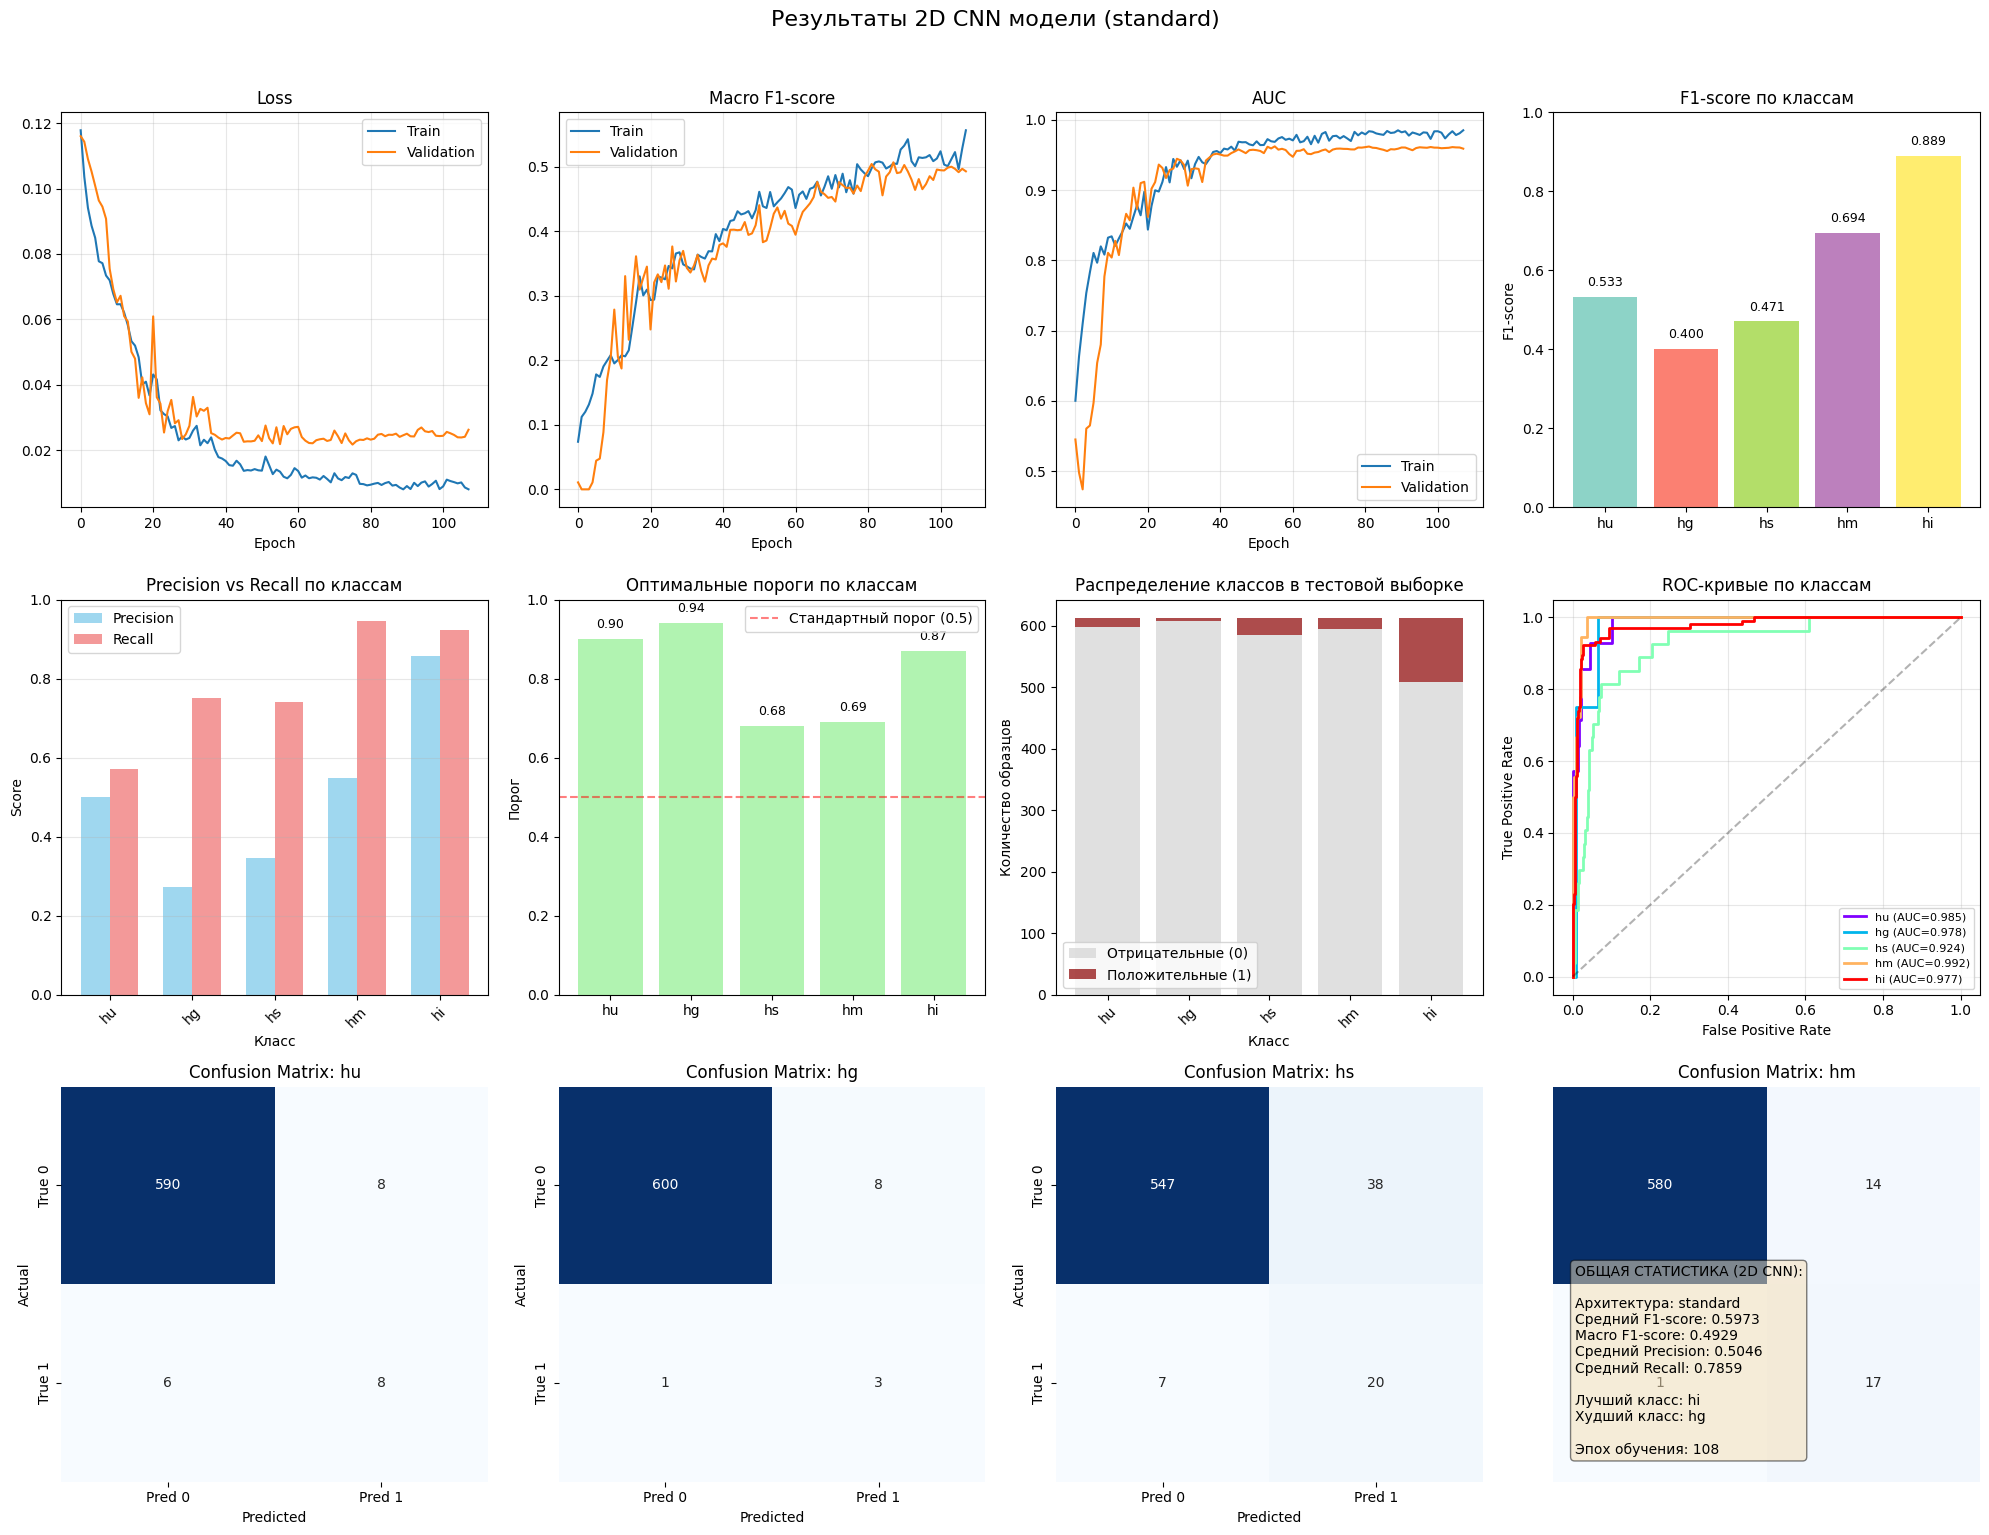

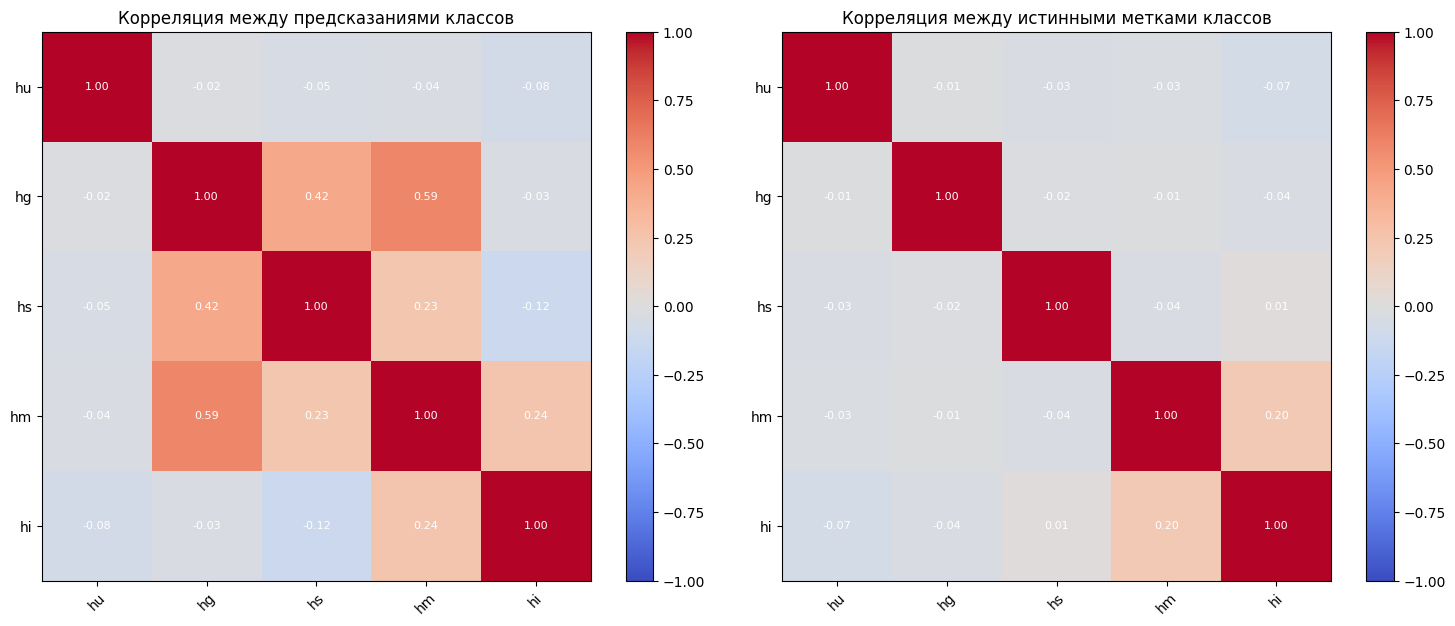


ФИНАЛЬНЫЕ ВЫВОДЫ (2D CNN)

 2D CNN модель успешно обучена!
  Архитектура: standard
  Лучший валидационный Macro F1-score: 0.5069
  Средний тестовый F1-score: 0.5973
  Лучшая эпоха: 88
  Использованные пороги: ['0.90', '0.94', '0.68', '0.69', '0.87']


In [33]:
# Конфигурация
INPUT_SHAPE = (25, 16, 1)  # Изменено для 2D CNN: (height, width, channels)
NUM_CLASSES = 5
CLASS_NAMES = ['hu', 'hg', 'hs', 'hm', 'hi']
EXTRACTOR_TYPE = 'standard'  # 'standard', 'deeper', 'separable', 'residual'

print("="*50)
print("ЗАГРУЗКА ДАННЫХ ДЛЯ 2D CNN")
print("="*50)

data_loader = DataLoader()
X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test = data_loader.load_data()

print("\n" + "="*50)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ 2D CNN")
print("="*50)

preprocessor = DataPreprocessor2D()
X_train_2d = preprocessor.prepare_for_2d_cnn(X_train_cnn)
X_val_2d = preprocessor.prepare_for_2d_cnn(X_val_cnn)
X_test_2d = preprocessor.prepare_for_2d_cnn(X_test_cnn)

preprocessor.print_data_shapes(X_train_2d, X_val_2d, X_test_2d)

print("\n" + "="*50)
print("СОЗДАНИЕ ВЗВЕШЕННОЙ ФУНКЦИИ ПОТЕРЬ")
print("="*50)

loss_factory = LossFactory()
weighted_loss_func, class_weights_info = loss_factory.create_weighted_loss(y_train, CLASS_NAMES)

print("\n" + "="*50)
print("СОЗДАНИЕ 2D CNN МОДЕЛИ")
print("="*50)

model_factory = Model2DFactory()
model, feature_extractor = model_factory.create_full_model(
    INPUT_SHAPE, 
    NUM_CLASSES, 
    extractor_type=EXTRACTOR_TYPE,
    num_features=20,
    use_class_weights=True,
    y_train=y_train
)

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss=weighted_loss_func,
    metrics=[
        'accuracy',
        F1Score(threshold=0.5, name='f1_score'),
        MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        tf.keras.metrics.Recall(thresholds=0.5, name='recall')
    ]
)

model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_macro_f1',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_macro_f1',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        f'best_2d_cnn_{EXTRACTOR_TYPE}_model.h5',
        monitor='val_macro_f1',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ 2D CNN")
print("="*50)

trainer = ModelTrainer2D()
history = trainer.train_model(
    model=model,
    X_train=X_train_2d,
    y_train=y_train,
    X_val=X_val_2d,
    y_val=y_val,
    epochs=250,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

print("\n" + "="*50)
print("ОЦЕНКА 2D CNN МОДЕЛИ")
print("="*50)

threshold_optimizer = ThresholdOptimizer()
optimal_thresholds = threshold_optimizer.find_optimal_thresholds(model, X_val_2d, y_val, CLASS_NAMES)

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (2D CNN)")
print("="*50)

results_summary, y_pred_proba_test = threshold_optimizer.evaluate_with_thresholds(
    model, X_test_2d, y_test, CLASS_NAMES, optimal_thresholds
)

print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ 2D CNN")
print("="*50)

visualizer = Visualizer2D()
visualizer.visualize_results(history, results_summary, y_test, y_pred_proba_test, 
                            CLASS_NAMES, optimal_thresholds, EXTRACTOR_TYPE)

print("\n" + "="*50)
print("ФИНАЛЬНЫЕ ВЫВОДЫ (2D CNN)")
print("="*50)

best_val_f1 = max(history.history['val_macro_f1']) if 'val_macro_f1' in history.history else 0
avg_test_f1 = np.mean([r['f1'] for r in results_summary])
best_epoch = np.argmax(history.history['val_macro_f1']) + 1 if 'val_macro_f1' in history.history else len(history.history['loss'])

print(f"\n 2D CNN модель успешно обучена!")
print(f"  Архитектура: {EXTRACTOR_TYPE}")
print(f"  Лучший валидационный Macro F1-score: {best_val_f1:.4f}")
print(f"  Средний тестовый F1-score: {avg_test_f1:.4f}")
print(f"  Лучшая эпоха: {best_epoch}")
print(f"  Использованные пороги: {[f'{t:.2f}' for t in optimal_thresholds]}")

In [39]:
model_factory = Model2DFactory()
model, feature_extractor = model_factory.create_full_model(
    INPUT_SHAPE, 
    NUM_CLASSES, 
    extractor_type=EXTRACTOR_TYPE,
    num_features=20,
    use_class_weights=True,
    y_train=y_train
)

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss=weighted_loss_func,
    metrics=[
        'accuracy',
        F1Score(threshold=0.5, name='f1_score'),
        MacroF1Score(num_classes=NUM_CLASSES, name='macro_f1'),
        tf.keras.metrics.AUC(multi_label=True, name='auc'),
        tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        tf.keras.metrics.Recall(thresholds=0.5, name='recall')
    ]
)

model.summary()
feature_extractor.summary()

/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "2D_CNN_Standard"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2D_CNN_Feature_Extractor        │ (None, 20)             │       103,124 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout1 (Dropout)   │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense2 (Dense)       │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,641 (404.85 KB)

 Trainable params: 103,193 (403.10 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "2D_CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 25, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,124 (402.83 KB)

 Trainable params: 102,676 (401.08 KB)

 Non-trainable params: 448 (1.75 KB)